In [2]:
from google.colab import drive
drive.mount('/content/drive', timeout_ms=1000000)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
%cd /content/drive/My\ Drive/Image Captioning

/content/drive/My Drive/Image Captioning


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import pickle
from pickle import dump , load
from PIL import Image, ImageDraw
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Sequential
from tqdm import tqdm
from time import time
from joblib import dump, load
import joblib
from keras.applications.inception_v3 import preprocess_input

In [6]:
# For loading the pickle file.
def unpickle_file(filename):
  with open(filename, 'rb') as f:
    return pickle.load(f)

In [7]:
# convert image into 64*64 array
def visualize_image(path):
  img = cv.imread(path)
  img_rgb = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  return cv.resize(img_rgb,(299,299),interpolation = cv.INTER_CUBIC)

In [8]:
path = os.path.join(os.getcwd(),'Images')
train_dict_path = os.path.join(os.getcwd(),'dict_pkl','train_dict.pkl')
val_dict_path = os.path.join(os.getcwd(),'dict_pkl','val_dict.pkl')
test_dict_path = os.path.join(os.getcwd(),'dict_pkl','test_dict.pkl')

# print(train_dict_path)

train_dict = unpickle_file(train_dict_path)        # unpickle the train_dict dictionary
print(f'Length of train_dict: {len(train_dict.keys())}')
print(f'Train Dict path: {train_dict_path}')
print(f'val Dict path: {val_dict_path}')
print(f'test Dict path: {test_dict_path}')

Length of train_dict: 6000
Train Dict path: /content/drive/My Drive/Image Captioning/dict_pkl/train_dict.pkl
val Dict path: /content/drive/My Drive/Image Captioning/dict_pkl/val_dict.pkl
test Dict path: /content/drive/My Drive/Image Captioning/dict_pkl/test_dict.pkl


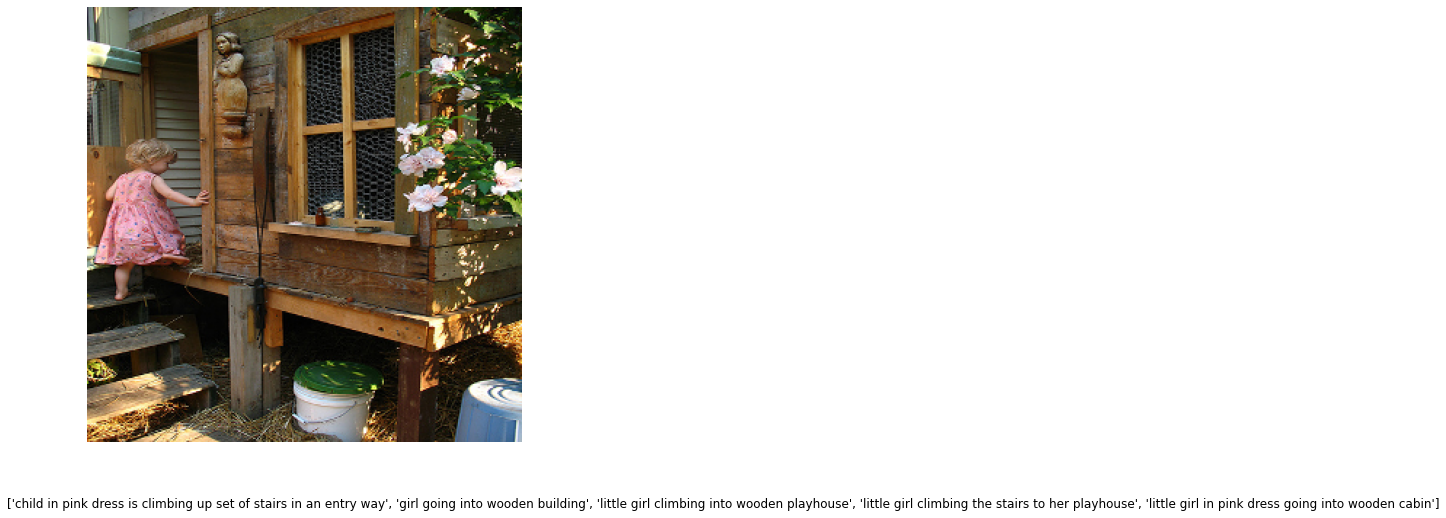

In [ ]:
# Example of the train image and its five captions for these images.

for i,(img_id,*cap_lst) in enumerate(train_dict.items()):
  img_path = os.path.join(path,img_id)
  img = visualize_image(img_path)
  img = np.squeeze(img.reshape((299,299,3)))
  plt.figure(figsize=(10,8))
  plt.imshow(img)
  plt.axis('off')
  plt.figtext(0.1, 0.01, str(cap_lst[0]), wrap=True, horizontalalignment='left', fontsize=12)
  plt.show()
  if i==0:
    break

#**Image Encodings Using Inception**

In [9]:
inception_model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 8s 0us/step


In [10]:
print(f'Last 2 layers: {inception_model.layers[-2:]}')             # last 2-layers not required because it is used to predict the classes in actual inception model.
print(f'Inception Model Input: {inception_model.input} ') 
print(f'Inception Model second last Layer output: {inception_model.layers[-2].output}')     
      

Last 2 layers: [<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f7d4656bef0>, <keras.layers.core.Dense object at 0x7f7d4656be48>]
Inception Model Input: Tensor("input_1:0", shape=(None, 299, 299, 3), dtype=float32) 
Inception Model second last Layer output: Tensor("avg_pool/Mean:0", shape=(None, 2048), dtype=float32)


In [11]:
model = Model(inception_model.input, inception_model.layers[-2].output)       # creating the separate model using Model as input shape (299,299) 

In [13]:
def create_img_encoding(dict_path, img_path, model_clf):

  dict_file = unpickle_file(dict_path)         # unpickle the dictionary by providing the path.
  encodings_dict = {}                # consider the encodings in dict format
  start = time()                     # taking the start time.

  for i,img_id in tqdm(enumerate(dict_file.keys())):

    img_path = os.path.join(path,img_id)
    image = visualize_image(img_path)                        # returns the image of shape (299,299,3)
    image = preprocess_input(image)                          # preprocess the input for Inception Model
    image = np.expand_dims(image, axis=0)                    # for model input in 4-d e.g.--> (1,299,299,3)

    img_encod = model_clf.predict(image)                     # return the image encoding (1,2048)
    img_encod_1 = np.reshape(img_encod, img_encod.shape[1])  # reshape to (2048,)

    encodings_dict[img_id] = img_encod_1                      # saving the encodings in the dict

  
  print(time()-start)                                         # checking how much time it will take 

  return encodings_dict


In [14]:
print(f'Train_encodings:--')
train_encodings = create_img_encoding(train_dict_path, path, model)           # taking the training encodings

print(f'Validation_encodings:--')
val_encodings = create_img_encoding(val_dict_path, path, model)               # taking the val_encodings

print(f'Test Encodings:--')
test_encodings = create_img_encoding(test_dict_path, path, model)             # taking the test_encodings


0it [00:00, ?it/s]

Train_encodings:--


6000it [1:12:54,  1.37it/s]


4374.015767812729
Validation_encodings:--


1091it [13:20,  1.36it/s]


800.0497851371765
Test Encodings:--


1000it [11:59,  1.39it/s]

719.5941934585571


In [ ]:
val_encodings = create_img_encoding(val_dict_path, path, model)              # taking the val_encodings

1091it [00:36, 29.85it/s]

36.54963564872742


In [ ]:
test_encodings = create_img_encoding(test_dict_path, path, model)           # taking the test_encodings

1000it [00:33, 30.20it/s]

33.11957883834839


In [ ]:
print(f'Train Encodings dictionary length: {len(train_encodings.keys())}')
print(f'Val Encodings dictionary length: {len(val_encodings.keys())}')
print(f'Test Encodings dictionary length: {len(test_encodings.keys())}')

Train Encodings dictionary length: 6000
Val Encodings dictionary length: 1091
Test Encodings dictionary length: 1000


In [15]:
def pickle_file(file_path, file, file_name):
  pickle.dump(file, open(os.path.join(file_path,file_name),'wb'))

In [16]:
file_path = os.path.join(os.getcwd(),'Image_encodings')

pickle_file(file_path, train_encodings, 'train_encodings.pkl')               # pickle the train 
pickle_file(file_path, val_encodings, 'val_encodings.pkl')
pickle_file(file_path, test_encodings, 'test_encodings.pkl')   
print('Finished')


Finished


In [17]:
# dump the model weights
joblib.dump(model,'inception.joblib') 

['inception.joblib']

#**Code Check**

In [ ]:
check2 = create_img_encoding(train_dict_path, path, model)

In [ ]:
print(check2.keys())

dict_keys(['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg'])


In [ ]:
check2['1000268201_693b08cb0e.jpg'].shape

(2048,)

In [ ]:
op = visualize_image(img_path)


# op = np.expand_dims(op,axis=0)
print(op.shape)


(299, 299, 3)


In [ ]:
ans = model.predict(op)

In [ ]:
ch = np.reshape(ans,ans.shape[1])
print(ch.shape)

(2048,)


In [ ]:
ch

array([7.7368875 , 3.2374158 , 3.014025  , ..., 1.2315866 , 0.05315058,
       2.3366473 ], dtype=float32)